In [1]:
import pandas as pd # spracovanie dát, CSV subor I/O
import numpy as np # lineara algebra
from sklearn.preprocessing import StandardScaler # použtie pre škálovanie údajov
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import metrics
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor
import seaborn as sns
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# načitanie suboru train.csv
df_train = pd.read_csv('train.csv', index_col=0)

In [3]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<h3>Príprava dát</h3>
-Zistovanie, ktoré údaje majú lineárny alebo nejaký iný vzťah k predajnej cene(Sale price)<br>
-Odstránenie menej podstatných stĺpcov<br>
-Odstránenie stĺpcov, ktoré majú veľa NaN hodnôt</br>

In [4]:
# zhrnutie popisných štatistík
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

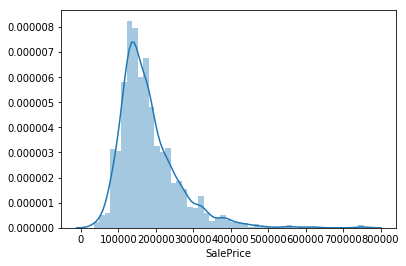

In [6]:
#histogram
sns.distplot(df_train['SalePrice']);

In [7]:
# šikmosť(skewness) a špicatosť(kurtosis)
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


-Šikmosť znamená, že horná časť graf nie je v strede, ale skôr vľavo alebo vpravo.<br>
-Špicatosť opisuje, či je gaussovská krivka veľmi malá a úzka alebo veľmi široká 


<h3>Použil som heatmapu, aby som zistil, ktoré vlastnosti(sltpce) majú najsilnejší vzťah s cenou domu (house price)</h3>

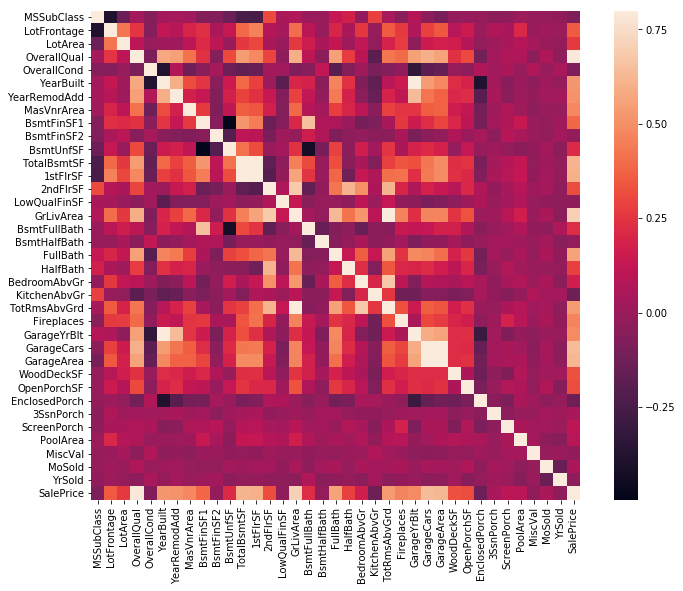

In [8]:
# korelačná matica
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

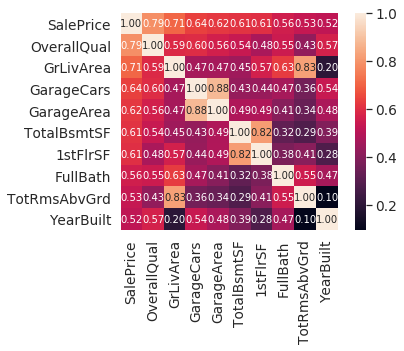

In [9]:
#saleprice korelačná matica
k = 10 #počet premenných pre heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

- GarageCars and GarageArea sú 2 dôležité hodnoty ale GarageArea nepoužijem pretože sú to viac-menej rovnaké informácie ako GarageCars<br>
- TotalBsmtSF a 1stFlrSF sú tiež viac-menej rovnaké, takže hodnotu 1StFlrSF nepoužijem<br>
- TotRmsAbvGrd a GrLivArea majú tiež silnu koreláciu takže TotRmsAbvGrd nepoužijem<br>
- Ostatné hodnoty zachovám

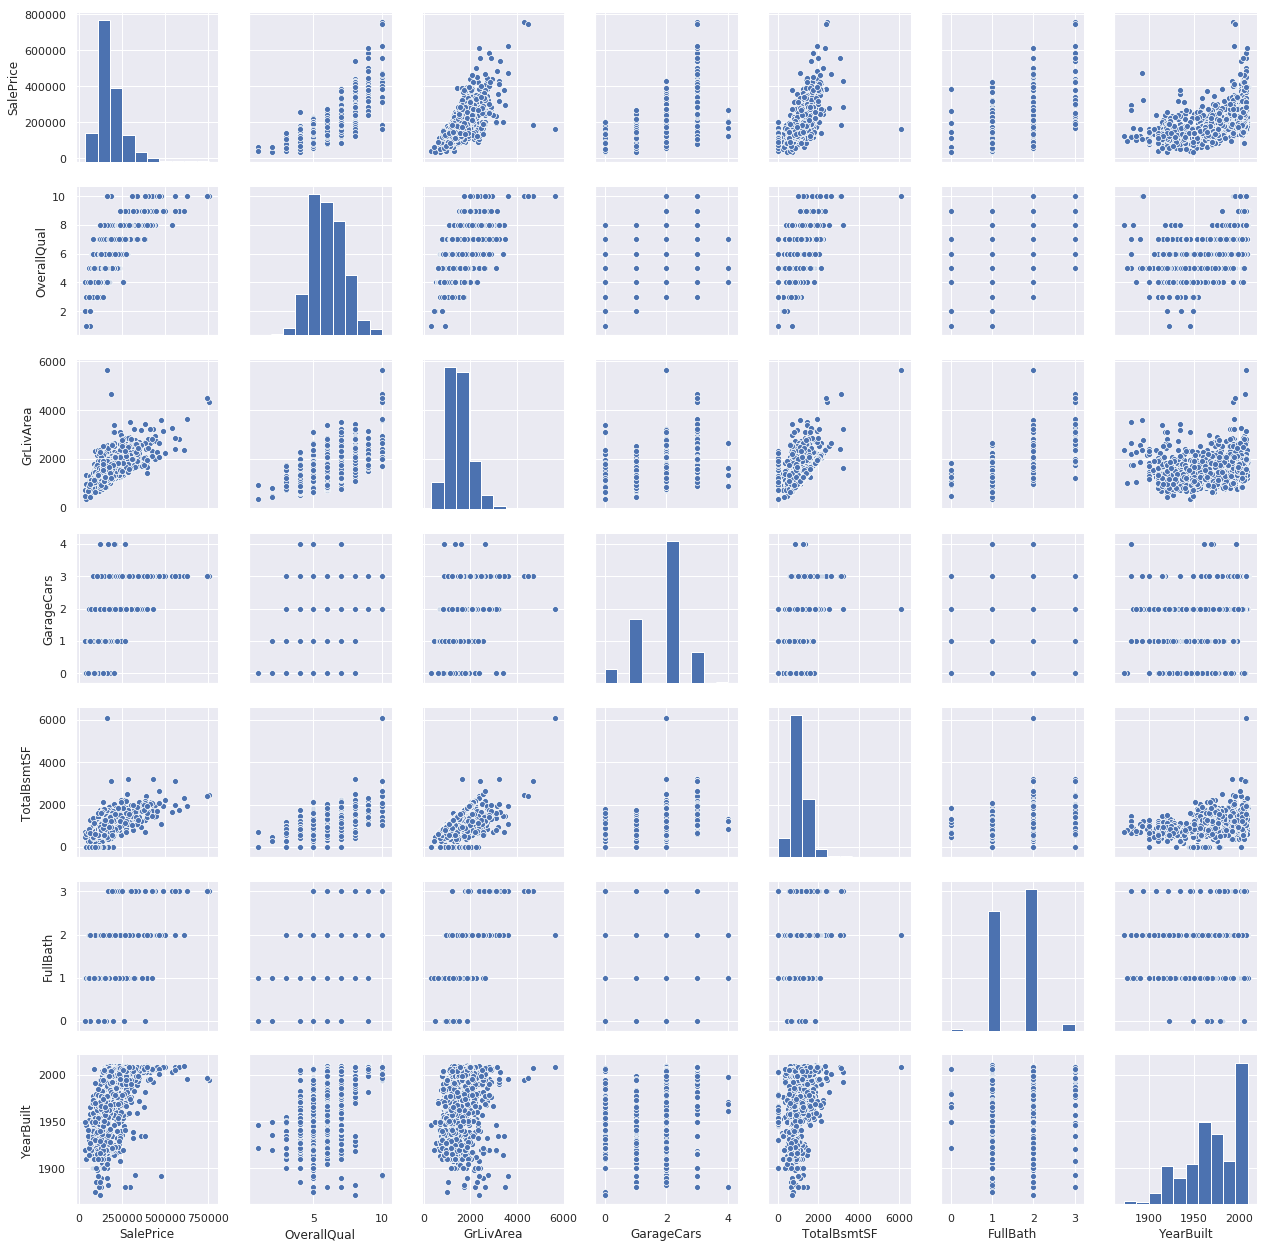

In [10]:
# bodový diagram
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], height = 2.5)
plt.show();

Zdá sa, že pivničné priestory(basement area) a celková obytná plocha(living area) majú podobnosť, že ich predajná cena pozemku vyzerá takmer identicky, preto odstranim hodnotu pivničné priestory(basement area).<br>
Možme tiež odstrániť údaje year built, pretože môžu byť veľmi zložite na použitie. 

In [11]:
# Pozrime sa na chýbajúce údaje.
# Zobrazime % údajov, ktoré chýbajú v niektorých stĺpcoch. 

total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageCond,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479


Niektoré z týchto funkcií sú pre nás zaujímavé a nevykazujú masívny nedostatok údajov, čo umožňuje vytvárať priemerné údaje pre tieto hodnoty. 

In [12]:
df_train = df_train.fillna(df_train.mean())

In [14]:
# štandardizáciu údajov
saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83870376]
 [-1.83352844]
 [-1.80092766]
 [-1.78329881]
 [-1.77448439]
 [-1.62337999]
 [-1.61708398]
 [-1.58560389]
 [-1.58560389]
 [-1.5731    ]]

outer range (high) of the distribution:
[[3.82897043]
 [4.04098249]
 [4.49634819]
 [4.71041276]
 [4.73032076]
 [5.06214602]
 [5.42383959]
 [5.59185509]
 [7.10289909]
 [7.22881942]]


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


- Hodnoty, ktoré sú si podobné, zostávajú blízko 0<br>
- Hodnoty, ktoré majú vysoké hodnoty, sú hodnoty ako 7.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


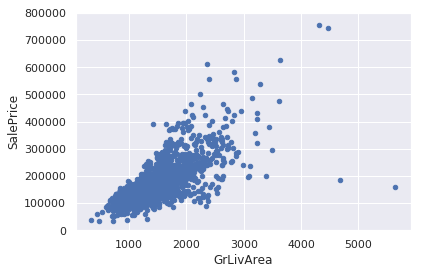

In [15]:
# bivariate analýza saleprice/grlivarea
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

Práve teraz si myslím, že mám predstavu o tom, aké údaje nás zaujímajú a aké údaje pre nás nie sú užitočné.

In [16]:
df_train = pd.read_csv('train.csv')

In [17]:
cols = ['SalePrice','OverallQual', 'GrLivArea', 'GarageCars', 'FullBath', 'YearBuilt']
df_train = df_train[cols]
# vytvorenie fiktívnych hodnôt
df_train = pd.get_dummies(df_train)
# naplnenie NA stredom stĺpca:
df_train = df_train.fillna(df_train.mean())
# pred použitím NN vždy štandardna zmena údajov
scale = StandardScaler()
X_train = df_train[['OverallQual', 'GrLivArea', 'GarageCars', 'FullBath', 'YearBuilt']]
X_train = scale.fit_transform(X_train)
# Y je len 'SalePrice' stlpec
y = df_train['SalePrice'].values
seed = 7
np.random.seed(seed)
# rozdelenie na 67% pre trenovacie data 33% pre testovacie data
X_train, X_test, y_train, y_test = train_test_split(X_train, y, test_size=0.33, random_state=seed)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [18]:
def create_model():
    # vytvorenie modelu
    model = Sequential()
    model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(1))
    # kompilacia modelu
    model.compile(optimizer ='adam', loss = 'mean_squared_error', 
              metrics =[metrics.mae])
    return model

In [19]:
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_2 (Dense)              (None, 30)                330       
_________________________________________________________________
dense_3 (Dense)              (None, 40)                1240      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 41        
Total params: 1,671
Trainable params: 1,671
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=150, batch_size=32)

Train on 978 samples, validate on 482 samples
Epoch 1/150
978/978 [==============================] - 1s 526us/step - loss: 38028804749.3497 - mean_absolute_error: 179315.7527 - val_loss: 41089219732.7137 - val_mean_absolute_error: 184177.8979
Epoch 2/150
978/978 [==============================] - 0s 82us/step - loss: 38028374660.9734 - mean_absolute_error: 179314.5516 - val_loss: 41088478462.9378 - val_mean_absolute_error: 184175.9308
Epoch 3/150
978/978 [==============================] - 0s 69us/step - loss: 38027059920.3599 - mean_absolute_error: 179310.8421 - val_loss: 41086103823.9336 - val_mean_absolute_error: 184169.5497
Epoch 4/150
978/978 [==============================] - 0s 91us/step - loss: 38023143976.8344 - mean_absolute_error: 179299.7556 - val_loss: 41079471235.7178 - val_mean_absolute_error: 184151.6018
Epoch 5/150
978/978 [==============================] - 0s 76us/step - loss: 38012784908.0409 - mean_absolute_error: 179270.6319 - val_loss: 41063271593.9585 - val_mean_a

Epoch 43/150
978/978 [==============================] - 0s 84us/step - loss: 3710188879.0511 - mean_absolute_error: 45687.9772 - val_loss: 3397797813.1120 - val_mean_absolute_error: 45327.2423
Epoch 44/150
978/978 [==============================] - 0s 78us/step - loss: 3649049354.9939 - mean_absolute_error: 45223.9101 - val_loss: 3337193843.7842 - val_mean_absolute_error: 44884.3209
Epoch 45/150
978/978 [==============================] - 0s 95us/step - loss: 3600737127.1329 - mean_absolute_error: 44913.9397 - val_loss: 3292202979.1867 - val_mean_absolute_error: 44560.2891
Epoch 46/150
978/978 [==============================] - 0s 80us/step - loss: 3550159426.4867 - mean_absolute_error: 44456.1762 - val_loss: 3232328916.3154 - val_mean_absolute_error: 44114.2507
Epoch 47/150
978/978 [==============================] - 0s 72us/step - loss: 3503552708.3190 - mean_absolute_error: 44126.9673 - val_loss: 3195337988.5145 - val_mean_absolute_error: 43849.3185
Epoch 48/150
978/978 [=============

978/978 [==============================] - 0s 88us/step - loss: 2263008374.8384 - mean_absolute_error: 33586.2985 - val_loss: 1960824951.2365 - val_mean_absolute_error: 33093.0141
Epoch 86/150
978/978 [==============================] - 0s 66us/step - loss: 2241470717.6442 - mean_absolute_error: 33409.4549 - val_loss: 1949003880.6307 - val_mean_absolute_error: 32970.0981
Epoch 87/150
978/978 [==============================] - 0s 76us/step - loss: 2223753781.3988 - mean_absolute_error: 33244.9731 - val_loss: 1935492962.3900 - val_mean_absolute_error: 32816.5109
Epoch 88/150
978/978 [==============================] - 0s 81us/step - loss: 2204525621.9223 - mean_absolute_error: 33094.4185 - val_loss: 1920276465.9253 - val_mean_absolute_error: 32654.4105
Epoch 89/150
978/978 [==============================] - 0s 138us/step - loss: 2187626424.9325 - mean_absolute_error: 32922.8562 - val_loss: 1905587197.6100 - val_mean_absolute_error: 32486.4065
Epoch 90/150
978/978 [=========================

978/978 [==============================] - 0s 89us/step - loss: 1735830293.4642 - mean_absolute_error: 28585.3430 - val_loss: 1597042650.0913 - val_mean_absolute_error: 28955.8266
Epoch 128/150
978/978 [==============================] - 0s 83us/step - loss: 1727840609.5051 - mean_absolute_error: 28515.6201 - val_loss: 1587987107.4523 - val_mean_absolute_error: 28910.4347
Epoch 129/150
978/978 [==============================] - 0s 91us/step - loss: 1724378328.9980 - mean_absolute_error: 28504.2703 - val_loss: 1580526255.6680 - val_mean_absolute_error: 28844.3851
Epoch 130/150
978/978 [==============================] - 0s 114us/step - loss: 1714220680.7689 - mean_absolute_error: 28394.0623 - val_loss: 1588979270.3734 - val_mean_absolute_error: 28819.1433
Epoch 131/150
978/978 [==============================] - 0s 85us/step - loss: 1706468986.5031 - mean_absolute_error: 28285.9244 - val_loss: 1584101055.0705 - val_mean_absolute_error: 28762.3059
Epoch 132/150
978/978 [====================

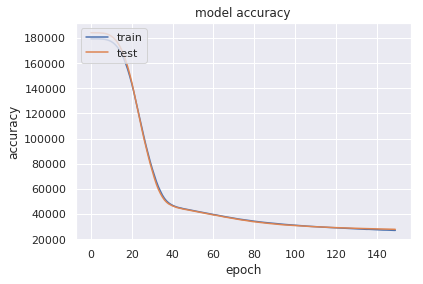

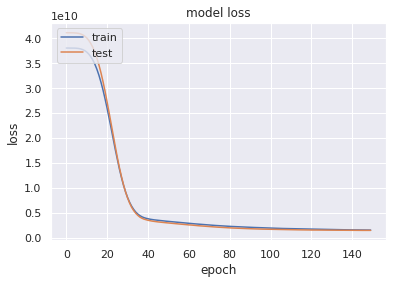

In [21]:
# Pozrime sa, ako dobre tento model funguje
# zhrnutie historie presnosti
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# zhrnutie historie chýb
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Tento výsledok nie je veľmi dobrý a dáva nám priemernú absolútnu chybu tesne nad 20000 dolárov. Verím, že tento model je nepresný v dôsledku skutočnosti, že máme dosť malý dátový súbor, pretože neurónová sieť funguje presnejšie, keď má veľký súbor údajov.

In [22]:
df_test = pd.read_csv('test.csv')
cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'FullBath', 'YearBuilt']
id_col = df_test['Id'].values.tolist()
df_test['GrLivArea'] = np.log1p(df_test['GrLivArea'])
df_test = pd.get_dummies(df_test)
df_test = df_test.fillna(df_test.mean())
X_test = df_test[cols].values
# pred použitím NN vždy štandardna zmena údajov
scale = StandardScaler()
X_test = scale.fit_transform(X_test)

In [23]:
prediction = model.predict(X_test)

In [24]:
submission = pd.DataFrame()
submission['Id'] = id_col
submission['SalePrice'] = prediction

In [25]:
submission.to_csv('submission.csv', index=False)